# Data Normalization

### Notebook Goals:
Investigate a few data normalization / standardization techniques to improve classical ML Models :)

In [1]:
from src.data.data_loader import load_data, get_train_validation_split
from src.tuning.benchmark import impute_missing_values

df = load_data(use_cached=True)
df, _ = get_train_validation_split(df)

c:\Users\viloh\Documents\nocturnal-hypo-gly-prob-forecast\.venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [80]:
p_data = df[df["p_num"] == "p06"]

In [81]:
y_feature = ["bg-0:00"]
x_features = [
    "hr-0:00",
    "steps-0:00",
    "cals-0:00",
    "cob",
    "carb_availability",
    "insulin_availability",
    "iob",
]

# Impute with default methods
p_data = impute_missing_values(p_data, columns=x_features)
p_data = impute_missing_values(p_data, columns=y_feature)

In [84]:
# choose first n hours
time_delta = 15  # 15 min intervals for -06
n_hours = 48
# person_data = p_data.iloc[:int((n_hours * 60) / 15)]
person_data = p_data
person_data.shape

(6802, 15)

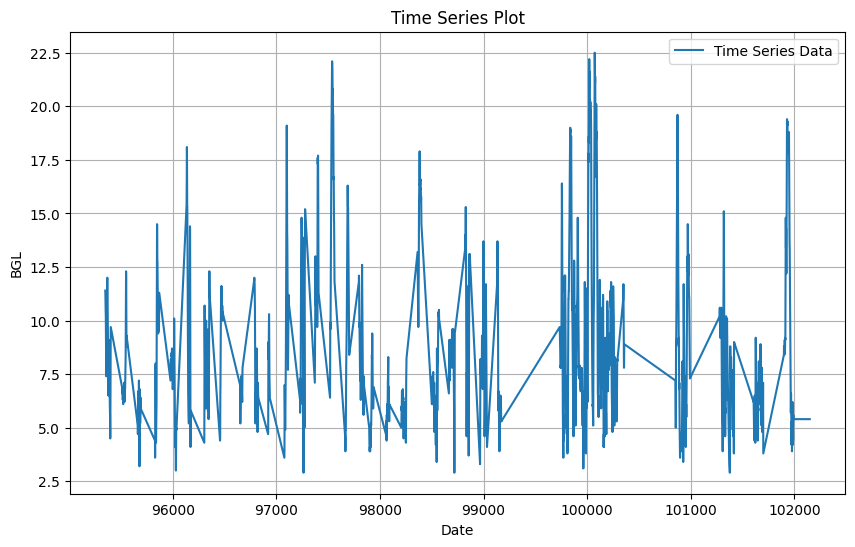

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the time series data
plt.figure(figsize=(10, 6))
plt.plot(person_data.index, person_data["bg-0:00"], label="Time Series Data")
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("BGL")
plt.legend()
plt.grid(True)
plt.show()

### Idea 1: Fourier Transform + Pruning

The paper [here](https://arxiv.org/pdf/2205.08897#page=12&zoom=100,110,922) describes the idea of "spectral bias". Essentially, the idea is that higher frequency components in the fourier transform act as the *noise*; so we delete frequency components beyond a particulat threshold to eliminate the noise. The lower frequency components can be used to reconstruct the time series data!

In [86]:
from sktime.transformations.series.fourier import FourierTransform

transformer = FourierTransform()
transformed = transformer.fit_transform(person_data["bg-0:00"])

#### Visualizing the fourier spectrum
Basic plot of the fourier spectrum. This confirms the spectral bias hypothesis; most of the "amplitude" is in the lower frequency range.

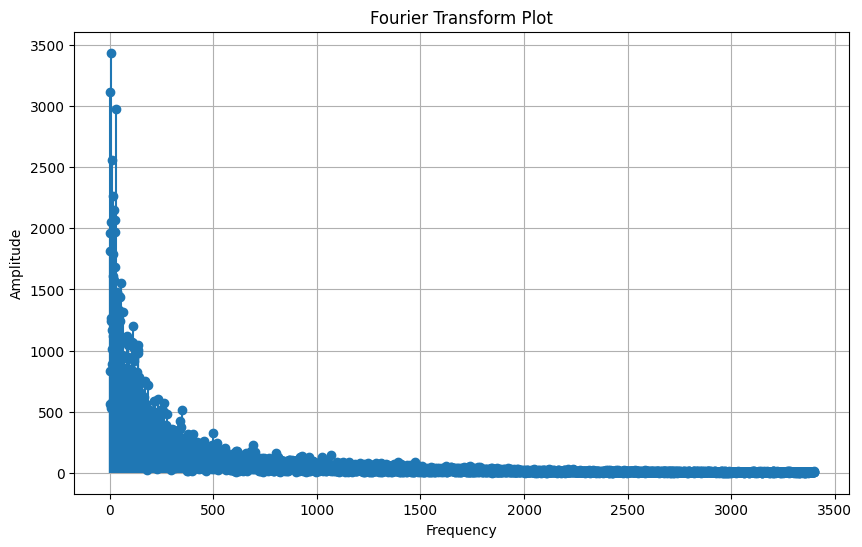

In [ ]:
import matplotlib.pyplot as plt

frequencies = transformed.index
amplitudes = transformed.values

# Plotting the Fourier transformed data
plt.figure(figsize=(10, 6))
plt.stem(frequencies, amplitudes, basefmt=" ")
plt.title("Fourier Transform Plot")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

#### Pop High Frequency Values

Pops the components that have high frequency, and reconstructs the original BGL data with the high frequency values removed

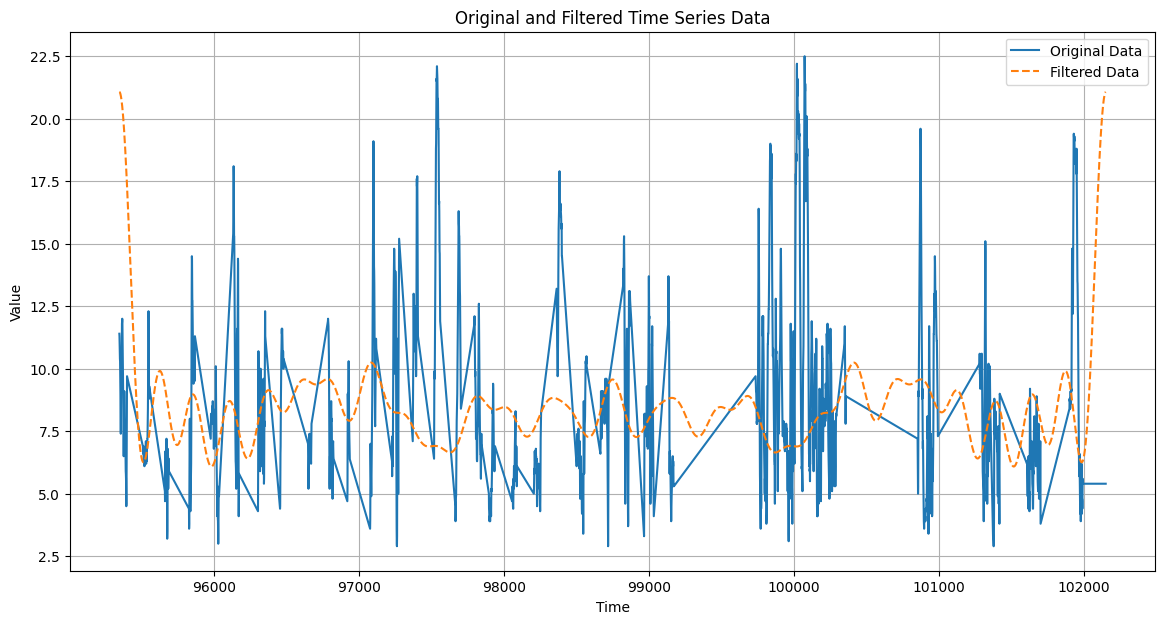

In [88]:
import numpy as np

frequency_threshold = 30

# Zero out high-frequency components
filtered_transformed = transformed.copy()
filtered_transformed[filtered_transformed.index > frequency_threshold] = 0

# filtered_transformed
# Perform inverse Fourier Transform to reconstruct the filtered data
filtered_data = np.fft.irfft(
    filtered_transformed.values, n=len(person_data), norm="backward"
)
# Cap time series tail and head to be at most 15
filtered_data[:300] = np.clip(filtered_data[:300], None, 15)  # Cap first 10 values
filtered_data[-300:] = np.clip(filtered_data[-300:], None, 15)  # Cap last 10 values
# Create a new dataframe for filtered data
filtered_data += np.mean(person_data["bg-0:00"])
filtered_df = pd.Series(filtered_data, index=person_data.index)


# Plot original and filtered data
plt.figure(figsize=(14, 7))
plt.plot(person_data.index, person_data["bg-0:00"], label="Original Data")
plt.plot(filtered_df.index, filtered_df, label="Filtered Data", linestyle="--")
plt.title("Original and Filtered Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
# plt.show()

## Idea 2: Wavelet Transform

I think that extensive use of linear imputation is causing some bad fourier transform coefficients. So maybe run a wavelet transform that can get the weighted "moving average" based on a function $\psi$

In [94]:
from sktime.transformations.panel.dwt import DWTTransformer

transformer = DWTTransformer(num_levels=1)
transformed = transformer.fit_transform(person_data["bg-0:00"])

In [96]:
def plot_items(data):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data, label="Filtered Data", linestyle="--")
    plt.title("Original and Filtered Time Series Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

In [ ]:
person_data = p_data.iloc[:288]  # choose a few hours (36 hrs)

c:\Users\viloh\Documents\nocturnal-hypo-gly-prob-forecast\.venv\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


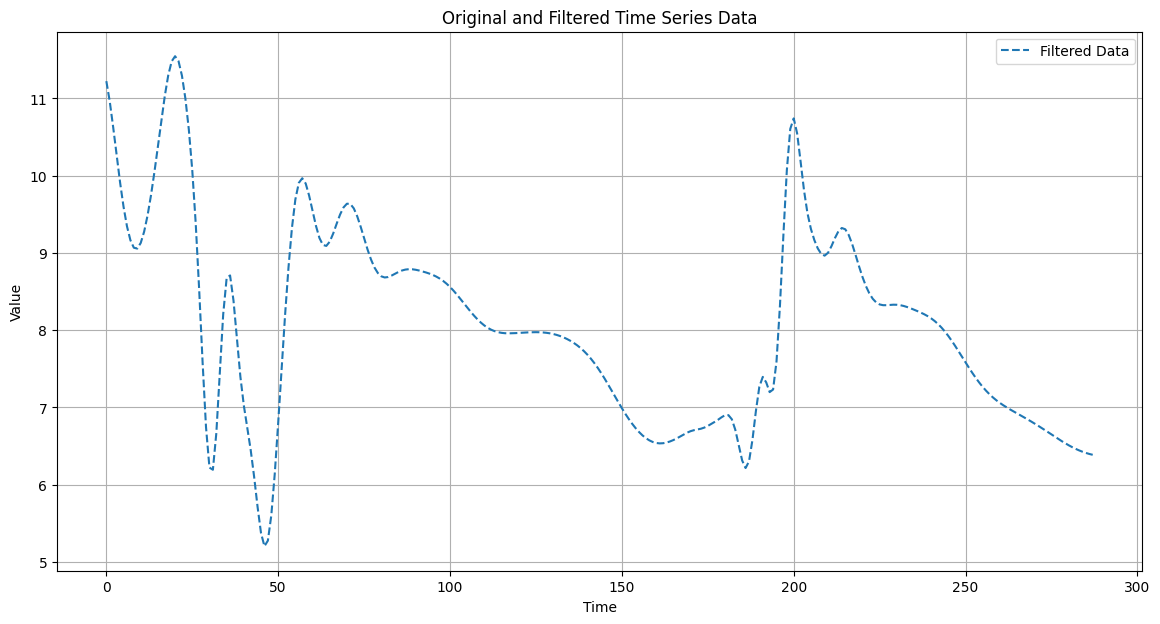

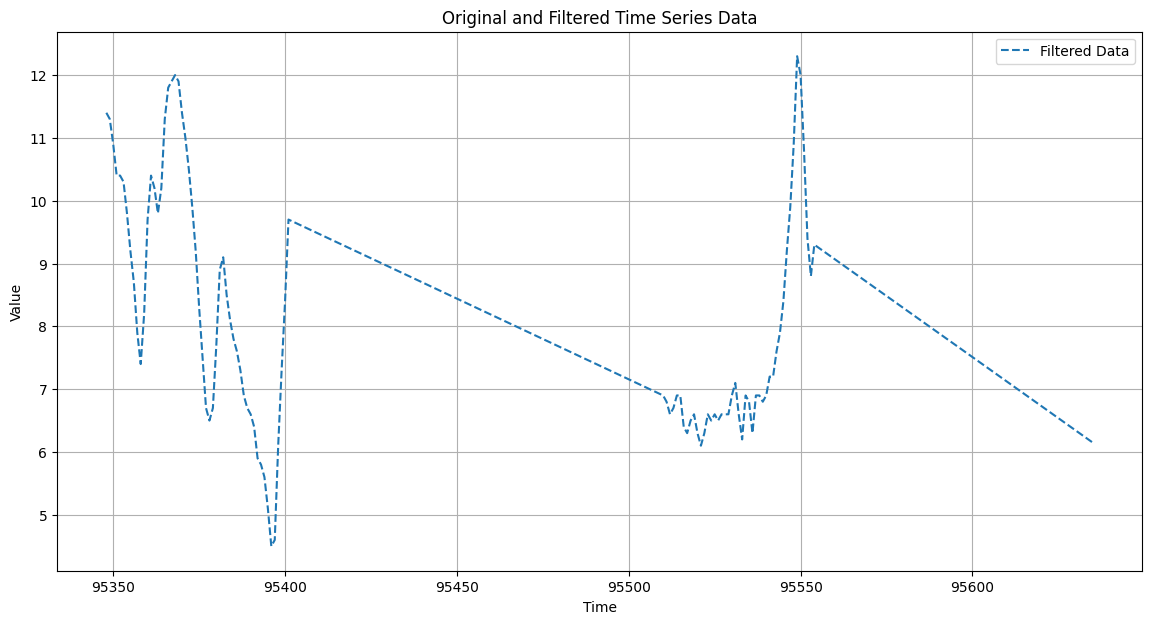

In [147]:
import pywt

wavelet = "sym16"  # you ccan find all wavelets in pywt.wavelist(kind='discrete') that is useful for our problem

# returns (cA_n, cD_n,...,cD1) where n is the 'levels', cA_n are the approx coeffs, cD's are the detailed coeffs
coeffs = pywt.wavedec(person_data["bg-0:00"], wavelet, level=5)

sigma = np.median(np.max(coeffs[-1])) / 0.6745
threshold = sigma * np.sqrt(2 * np.log(len(person_data)))

# apply thresholding to detail coefficients (keeping the approximation coefficients intact)- cA captures low-frequency stuff and cD's capture high frequency. We can smooth
# the data by removing part of the cD's (i.e zero it)
coeffs_new = coeffs.copy()
coeffs_new[1:] = [pywt.threshold(c, threshold, mode="hard") for c in coeffs[1:]]

# reconstruct the signal and plot!
smoothed_signal = pywt.waverec(coeffs_new, wavelet)
series = pd.Series(smoothed_signal)

plot_items(series)
plot_items(person_data["bg-0:00"])